# Add folders containing data and algorithms to current working path.

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/General_Functions")

CPU times: user 731 µs, sys: 793 µs, total: 1.52 ms
Wall time: 1.16 ms


# Double Gyre 

## Import Double Gyre Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/double_gyre.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 318 ms, sys: 83.2 ms, total: 401 ms
Wall time: 1.74 s


## Data/Parameters for Dynamical System

In [3]:
%%time
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 8

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

CPU times: user 377 µs, sys: 130 µs, total: 507 µs
Wall time: 472 µs


## Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 10

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 2
ymin = 0
ymax = 1

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.005

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

CPU times: user 669 µs, sys: 1 ms, total: 1.67 ms
Wall time: 1.36 ms


In [5]:
%%time
# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *
DS = Dynamical_System(params_data, params_DS)

CPU times: user 137 ms, sys: 28.1 ms, total: 165 ms
Wall time: 555 ms


## Interpolate Velocity

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 76 ms, sys: 34.4 ms, total: 110 ms
Wall time: 260 ms


## Compute Trajectories

In [7]:
trajectory_grid, velocity_grid = DS._trajectory_grid();

  0%|          | 0/51 [00:00<?, ?it/s]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done  51 out of  51 | elapsed:  6.6min finished


## Compute Gradient of Flow map over meshgrid of Initial Conditions

In [8]:
%%time
# aux_grid = True --> Use auxiliary grid for numerical computation of gradient. Otherwise aux_grid = False
aux_grid = True

grad_Fmap_grid = DS._grad_Fmap_grid(aux_grid)

  0%|          | 0/51 [00:00<?, ?it/s]

CPU times: user 1.48 s, sys: 75.2 ms, total: 1.55 s
Wall time: 27min 12s


## Compute Polar Rotation Angle

In [13]:
from ipynb.fs.defs.PRA import _PRA
PRA = _PRA(grad_Fmap_grid)

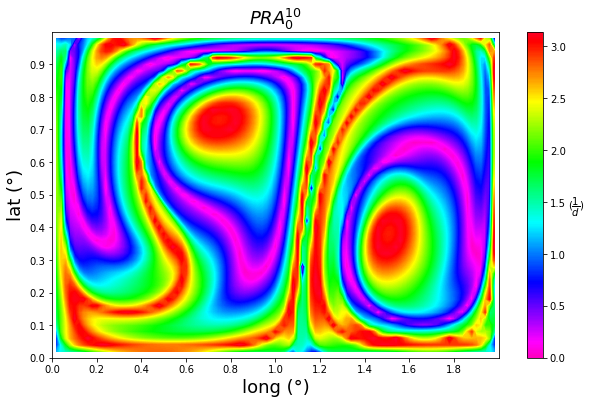

In [15]:
######################## PLOT RESULTS ########################

import matplotlib.pyplot as plt

# Figure/Axis
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, PRA, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 18)
ax.set_ylabel("lat (°)", fontsize = 18)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), .2))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), .1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, 3, 7, endpoint = True))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10)

# Title
ax.set_title(r'$ PRA $'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 18)

plt.show()